In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Cargar el dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Temp_Asu20092021.csv")

<ipython-input-59-634629b41b91>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Temperatura'] = data['Temperatura'].interpolate()


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores hiperparámetros:
{'alpha': 0.01}


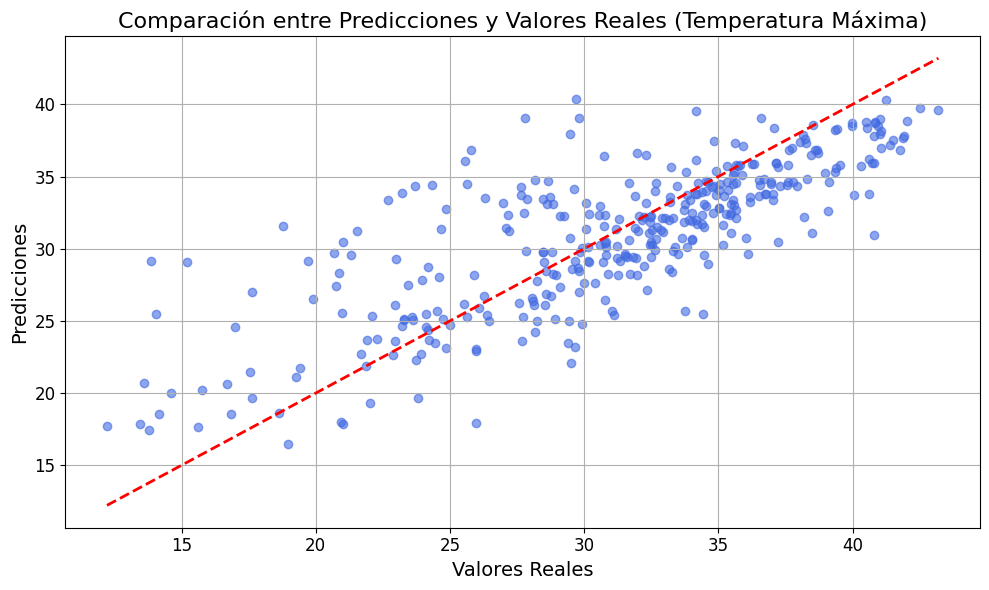

Comparación de Valores Reales y Predicciones:
         Fecha  Valor Real  Predicción  Diferencia
0   2021-01-01   37.035863   33.799894    3.235969
1   2021-01-02   40.793450   35.932699    4.860750
2   2021-01-03   29.466054   37.962934   -8.496880
3   2021-01-04   29.927540   30.048308   -0.120768
4   2021-01-05   34.018225   30.600306    3.417919
..         ...         ...         ...         ...
359 2021-12-26   39.333956   38.225421    1.108534
360 2021-12-27   40.783501   37.822642    2.960859
361 2021-12-28   42.042177   38.854791    3.187386
362 2021-12-29   43.197525   39.628131    3.569394
363 2021-12-30   41.244712   40.298522    0.946190

[364 rows x 4 columns]


In [59]:

# Convertir la columna 'Fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]

# Interpolar valores faltantes
data['Temperatura'] = data['Temperatura'].interpolate()

# Resamplear a intervalos diarios y calcular la temperatura máxima diaria
daily_max_temperatures = data['Temperatura'].resample('D').max()

# Agregar percentil 95 diario como covariable
percentil_95 = data['Temperatura'].resample('D').apply(lambda x: np.percentile(x, 95))

# Combinar características
features = pd.DataFrame({
    'Max_Temp': daily_max_temperatures,
    'Temp_Percentil_95': percentil_95
})

# Shift de la variable objetivo
features['Target'] = features['Max_Temp'].shift(-1)

# Eliminar el último día
features.dropna(inplace=True)

# Definir características y variable objetivo
X = features[['Max_Temp', 'Temp_Percentil_95']].values
y = features['Target'].values

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos en entrenamiento y validación
train_indices = features.index.year <= 2020
val_indices = features.index.year == 2021

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# Modelo de regresión Ridge
ridge = Ridge()

# Cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluar el modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Calcular métricas de evaluación
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Imprimir métricas
metrics_df = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Valor': [mse, rmse, mae, r2]
})

# Estilizar la tabla de métricas
styled_metrics = metrics_df.style.background_gradient(cmap='viridis')

# Mostrar la tabla de métricas
styled_metrics

# Crear tabla de comparación entre valores reales y predicciones
comparison_df = pd.DataFrame({
    'Fecha': features.index[val_indices],
    'Valor Real': y_val,
    'Predicción': y_pred,
    'Diferencia': y_val - y_pred
})

# Estilizar la tabla de comparación
styled_comparison = comparison_df.style.background_gradient(cmap='coolwarm')

# Mostrar la tabla de comparación
styled_comparison

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, color='royalblue', alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2)
plt.title('Comparación entre Predicciones y Valores Reales (Temperatura Máxima)', fontsize=16)
plt.xlabel('Valores Reales', fontsize=14)
plt.ylabel('Predicciones', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir la tabla comparativa final
print("Comparación de Valores Reales y Predicciones:")
print(comparison_df)